In [1]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(taxyvr)
library(cowplot)
install.packages("formattable")
library(formattable)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



# Investigation into Median Data Science Salaries

## INTRODUCTION

Increased use of data in decision-making across the economy has resulted in strong demand for those with Data Science qualifications.  Having witnessed a 650% increase in the last decade, employment growth for Data Scientists is projected to be 31.4% from 2020 to 2030 (Zair, C. 2021; Data Science Jobs Guide).  Given this buoyant outlook, what can Data Science professionals expect salary wise? In addition, the onset of COVID-19 has accelerated the prevalence of remote work, with fully remote teams increasing from 2.3% to 20% of total teams from pre-2019 to 2020 (Ozimek, 2020); we will explore whether there is a salary difference in remote-majority vs minority positions. To accommodate for the right-skew of our sample distributions, our project will investigate the median salary, median absolute deviation, and interquartile range of full-time Data Science professionals in the United States. Our report utilizes a dataset from Kaggle comprising of salary and other employment information anonymously submitted by Data Science professionals.

#### Note on terms used:

(1) remote-minorty position (remote_min): Less than 20% of the overall amount of work done remotely for position.

(2) remote-majority position (remote_maj): More than 80% of the overall amount of work done remotely for position.

(3) USD: United States Dollars

## METHODS AND RESULTS

### METHODS

Information within the dataset is self-reported, hence there is potential for selection bias.  However, because the submissions are anonymous, overall we may rely on the truthfulness of the submissions.  The data provides a reasonable number of observations (approximately 350) and is current (from 2020 to 2022). 

Performing a preliminary investigation, USD 140,000 was obtained as an estimate for the median income of full-time US Data Science professionals.  Our investigation also found that the median income for those working in remote-majority positions is USD 140,000 whereas the median income for those in remote-minority positions is USD 130,000.  On the basis of this preliminary investigation, it appears professionals in remote-majority positions can expect a higher salary than their remote-minority counterparts.
 
However, noting the two groups have substantial overlap in their interquartile range, that their medians are close to each other, and the presence of randomness and other confounding factors, this assessment is not sufficient to make definite conclusions on median salaries.  We will thus utilize bootstrapping on the two samples to produce a 90% confidence interval of the estimated median salary difference for full time Data Science professionals working in the US. 


Bootstrapping methods, rather than asymptotics, are appropriate for this investigation, given that we are invesigating median salaries.  If we had instead decided to investigate mean salaries, and assuming requirements for Central Limit Theorem were met, asymptotics may have been the preferred method. 
 
In addition, we will conduct two hypothesis tests at the 10% significance level.  The first will be to further investigate whether there is a true difference in median salaries, with our null hypothesis being that there is no difference in median pay between Data Science professionals employed remotely-majority compared to remote-minority positions.  Our alternative hypothesis is that there is a difference in median income between these two groups.

The second hypothesis test will be whether the true median income for Data Science professionals is USD 98,230, as reported by US News and World Report. The null hypothesis is that the true median income is the aforementioned pay, with our alternative hypothesis being that the true median is different from USD 98,230.
 
We expect to find a statistically significant difference in the true median income between remote-minority vs remote-majority Data Science professionals. We hope this investigation will assist Data Science professionals better assess their income opportunities. Additionally, considering remote employees have reported to be significantly happier than their non-remote counterparts (Elshaiekh et al., 2018), we hope this report will provide the salary insights necessary to inform decisions whether to pursue a remote vs non-remote career. Future questions would likely include whether confounding factors influenced differences in median salary observed and salary trends.

### RESULTS

#### 1. Prelinary Results
##### **Table 1.1** Orignal Data

In [2]:
original_data <- read_csv("ds_salaries.csv")
head(original_data)

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


##### **Table 1.2** Clean Data

In [3]:
# Cleaning the data to only show US residence, 0 and 100 remote ratio 
# and Full Time employment

clean_data <- original_data %>%
    filter(!is.na(salary_in_usd),
        employee_residence == "US",
            employment_type == "FT", 
        remote_ratio %in% c(0, 100)) %>%
    select(experience_level, salary_in_usd, remote_ratio)

head(clean_data)

experience_level,salary_in_usd,remote_ratio
<chr>,<dbl>,<dbl>
EN,72000,100
SE,190000,100
MI,135000,100
MI,87000,100
MI,85000,100
MI,98000,0


##### **Table 1.3** Calculations for summary data (min, max, median, mean, amount) related ot the different groups being explored.

In [4]:
remote_min_dist <-
    clean_data %>%
    filter(remote_ratio == 0)

remote_maj_dist <-
    clean_data %>%
    filter(remote_ratio == 100)

remote_min_median <- remote_min_dist %>% 
    summarise(median_0 = median(salary_in_usd)) %>%
    pull()

remote_maj_median <- remote_maj_dist %>% 
    summarise(median_100 = median(salary_in_usd)) %>%
    pull()

remote_min_mean <- remote_min_dist %>%
    summarise(mean_0 = mean(salary_in_usd)) %>%
    pull() %>%
    ceiling()

remote_maj_mean <- remote_maj_dist %>%
    summarise(mean_100 = mean(salary_in_usd)) %>%
    pull() %>%
    ceiling()

remote_min_min <- remote_min_dist %>%
    summarise(min_0 = min(salary_in_usd)) %>%
    pull()


remote_min_max <- remote_min_dist %>%
    summarise(min_0 = max(salary_in_usd)) %>%
    pull()

remote_min_amount <- 
    clean_data %>%
    summarise(amount_0 = sum(remote_ratio == 0)) %>%
    pull()

remote_maj_min <- 
    clean_data %>%
    filter(remote_ratio == 100) %>%
    summarise(min_100 = min(salary_in_usd)) %>%
    pull()

remote_maj_max <- remote_maj_dist %>%
    summarise(max_100 = max(salary_in_usd)) %>%
    pull()

remote_maj_amount <- 
    clean_data %>%
    summarise(amount_100 = sum(remote_ratio == 100)) %>%
    pull()

overall_mean <-
    clean_data %>%
    summarise(overall_mean = mean(salary_in_usd)) %>%
    pull() %>%
    ceiling()

overall_median <-
    clean_data %>%
    summarise(overall_median = median(salary_in_usd)) %>%
    pull()

overall_min <-
    clean_data %>%
    summarise(overall_min = min(salary_in_usd)) %>%
    pull()

overall_max <- 
    clean_data %>%
    summarise(overall_max = max(salary_in_usd)) %>%
    pull()

overall_amount <- remote_min_amount + remote_maj_amount

##### Scaling Parameters: Calculating MAD and Inter-quartile Range
Following cell includes operations to calculate the Median Absolute Deviation (MAD) and Interquartile Range for:

(1) datascientists overall
(2) remote-minority data scientists
(3) remote-majority data scientists

In [5]:
overall_mad <- mad(clean_data$salary_in_usd) %>% ceiling()

remote_min_mad <- mad(remote_min_dist$salary_in_usd) %>% ceiling()

remote_maj_mad <- mad(remote_maj_dist$salary_in_usd) %>% ceiling()

remote_min_quartile_1 <- quantile(pull(remote_min_dist, salary_in_usd), 0.25)
remote_min_quartile_3 <- quantile(pull(remote_min_dist, salary_in_usd), 0.75)
remote_maj_quartile_1 <- quantile(pull(remote_maj_dist, salary_in_usd), 0.25)
remote_maj_quartile_3 <- quantile(pull(remote_maj_dist, salary_in_usd), 0.75)
overall_quartile_1 <- quantile(pull(clean_data, salary_in_usd), 0.25)
overall_quartile_3 <- quantile(pull(clean_data, salary_in_usd), 0.75)

#### The following operations build a summary table

In [6]:
categories <- c("remote minority", "remote majority", "overall")
min <- c(remote_min_min, remote_maj_min, overall_min)
max <- c(remote_min_max, remote_maj_max, overall_max)
mean <- c(remote_min_mean, remote_maj_mean, overall_mean)
median <- c(remote_min_median, remote_maj_median, overall_median)
frequency <- c(remote_min_amount, remote_maj_amount, overall_amount)
first_quartile <- c(remote_min_quartile_1, remote_maj_quartile_1, overall_quartile_1)
third_quartile <- c(remote_min_quartile_3, remote_maj_quartile_3, overall_quartile_3)
median_absolute_deviation <- c(remote_min_mad, remote_maj_mad, overall_mad)

ratio_data_frame <- data.frame(categories, min, max, mean, median, first_quartile, third_quartile, median_absolute_deviation, frequency)

summary_table <- formattable(ratio_data_frame, align = c("l", rep("r", NCOL(ratio_data_frame) -1)))

##### **Table 1.4** Table of Summary Statistics

In [7]:
summary_table

categories,min,max,mean,median,first_quartile,third_quartile,median_absolute_deviation,frequency
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
remote minority,54000,450000,141254,130000,99050,172500,51076,67
remote majority,25000,600000,150821,140000,110000,175000,47785,244
overall,25000,600000,148760,140000,106260,175000,50409,311


In [8]:
min_shade <- tibble(lower_bound <- (remote_min_median - remote_min_mad)/1000, upper_bound <- (remote_min_median + remote_min_mad)/1000)
maj_shade <- tibble(lower_bound <- (remote_maj_median - remote_maj_mad)/1000, upper_bound <- (remote_maj_median + remote_maj_mad)/1000)
overall_shade <- tibble(lower_bound <- (overall_median - overall_mad)/1000, upper_bound <- (overall_median + overall_mad)/1000)

remote_min_plot <-
    remote_min_dist %>%
    ggplot(aes(x = salary_in_usd/1000)) + 
    geom_histogram(binwidth = 20, color="white", fill="darkgoldenrod1") +
    geom_vline(xintercept = remote_min_median/1000, color="red", size=2) +
    shade_confidence_interval(min_shade, fill="lightblue") +
    xlab("salary in thousands of USD") +
    ggtitle("Salaries of Professionals in Remote Minority Workplaces")

remote_maj_plot <-
    remote_maj_dist %>%
    ggplot(aes(x = salary_in_usd/1000)) + 
    geom_histogram(binwidth = 20, color="white", fill="purple") +
    geom_vline(xintercept = remote_maj_median/1000, color="red", size=2) +
    shade_confidence_interval(overall_shade, fill="lightblue") +
    xlab("salary in thousands of USD") +
    ggtitle("Salaries of Professionals in Remote Majority Workplaces")


overall_plot <-
    clean_data %>%
    ggplot(aes(x = salary_in_usd/1000)) +
    geom_histogram(binwidth = 20, color="white", fill="darkgreen") +
    geom_vline(xintercept = overall_median/1000, color="red", size=2) +
    shade_confidence_interval(overall_shade, fill="lightblue") +
    xlab("salary in thousands of USD") +
    ggtitle("Salary Distribution of Data Science Professionals")

##### **Figure 1.1** Histograms Illustrating Distributions of Salary

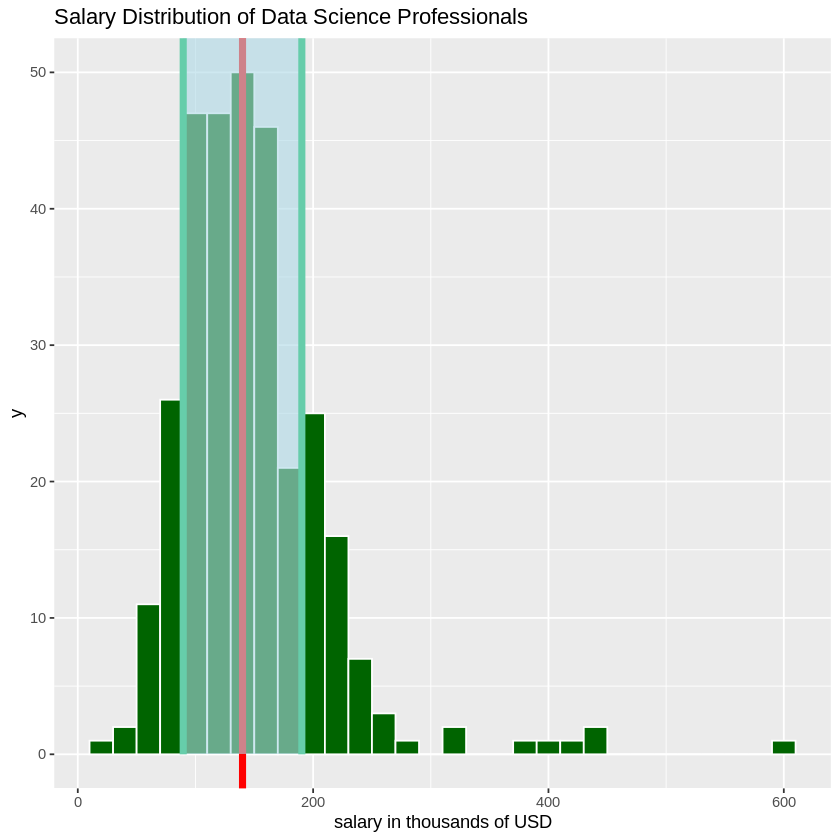

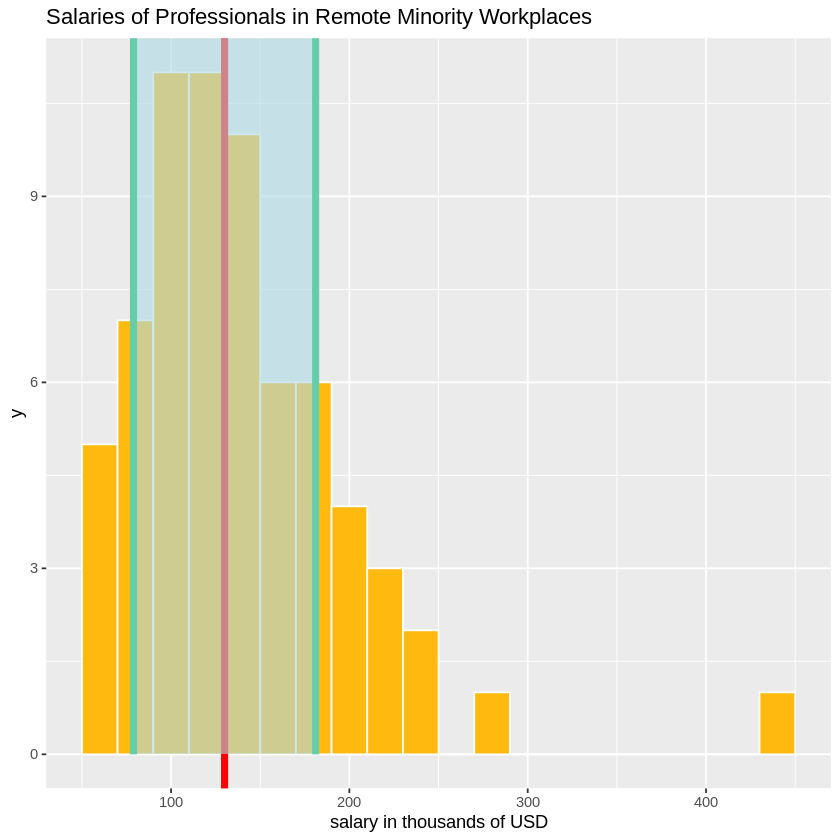

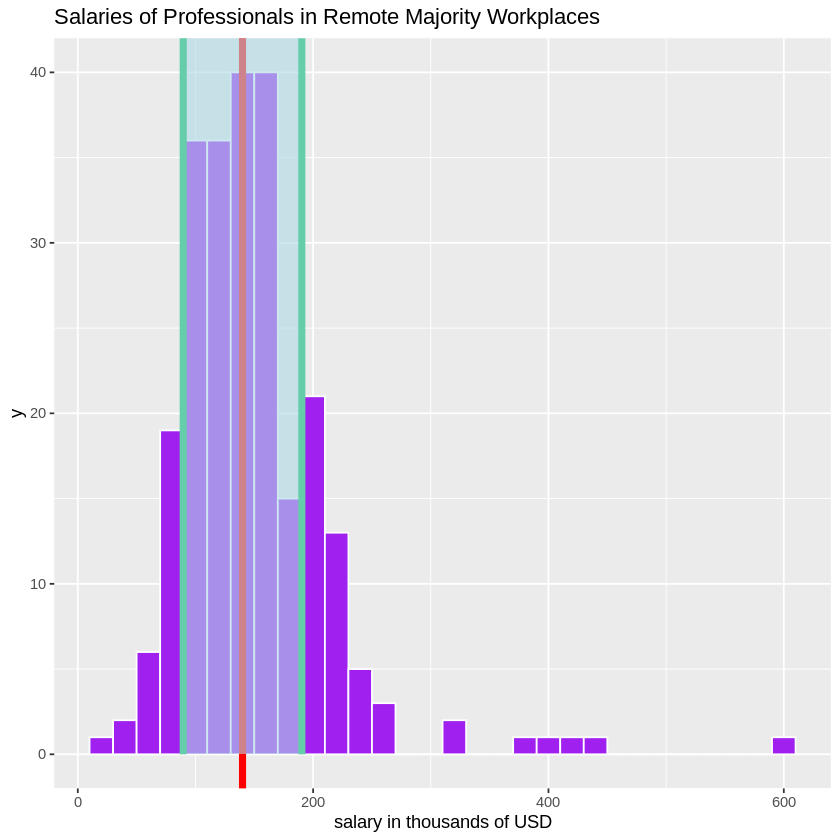

In [9]:
overall_plot
remote_min_plot
remote_maj_plot

In [10]:
# Boxplots of the data for ease of comparison

clean_data$remote_predominance <- factor(clean_data$remote_ratio,
                                levels=c(0, 100),
                                labels=c("remote minority", "remote majority"))

remote_ratio_boxplot <- 
    clean_data %>%
    ggplot(aes(y = salary_in_usd/1000, x = remote_predominance, fill=remote_predominance)) +
    geom_boxplot() +
    coord_cartesian(ylim = c(20, 600)) + 
    xlab("category of workplace (remote minority vs majority)") +
    ylab("salary (in thousands of US$)") +
    ggtitle("Salary Distribution for Data Science Professionals by Remote Category")

##### **Figure 1.2** Boxplot of Salary Distribution by Remote Category

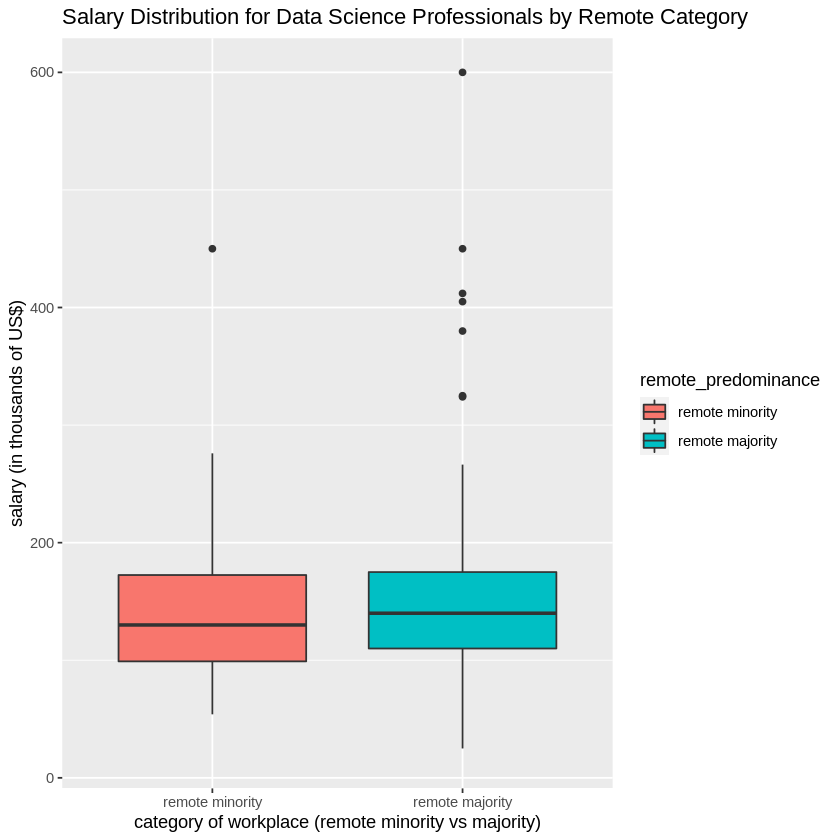

In [11]:
remote_ratio_boxplot

#### 2. Bootstrap Distributions

#### Bootstrap Distribution for Data Scientists (overall)

In [12]:
ds_workers <- original_data %>%
    filter(!is.na(salary_in_usd),
        employee_residence == "US",
            employment_type == "FT") %>%
    select(experience_level, salary_in_usd, remote_ratio)

##### **Table 2.1** Data Scientists Overall

In [13]:
ds_workers_median <- 140000/1000

ds_workers_bootstrap_dist <-
    ds_workers %>%
    specify(response = salary_in_usd) %>%
    generate(type="bootstrap", reps = 10000) %>%
    calculate(stat = "median")

head(ds_workers_bootstrap_dist)

replicate,stat
<int>,<dbl>
1,135000
2,136994
3,139300
4,135800
5,140000
6,140000


##### **Table 2.2** 90% Confidence Interval for Bootstrap Distribution of Data Scientists (overall)

In [14]:
ds_workers_ci <-
    ds_workers_bootstrap_dist %>%
    get_confidence_interval(level = 0.90, type = "percentile")

ds_workers_ci1 <- ds_workers_ci %>%
                  tibble(lower_ci1 = ds_workers_ci[[1]]/1000,  upper_ci1 = ds_workers_ci[[2]]/1000)%>%
                  select(lower_ci1, upper_ci1)

ds_workers_ci1 

lower_ci1,upper_ci1
<dbl>,<dbl>
135,144


We are 90% confidence that the true median salary for Data Scientists (overall) lies somewhere between USD 135000 and USD 144000. Note that the Null Hypothesis median salary of USD 98230 is not contained within this interval.

##### **Figure 2.1** Histogram of Bootstrap Distribution with 90% Confidence Interval for Data Scientists (overall)

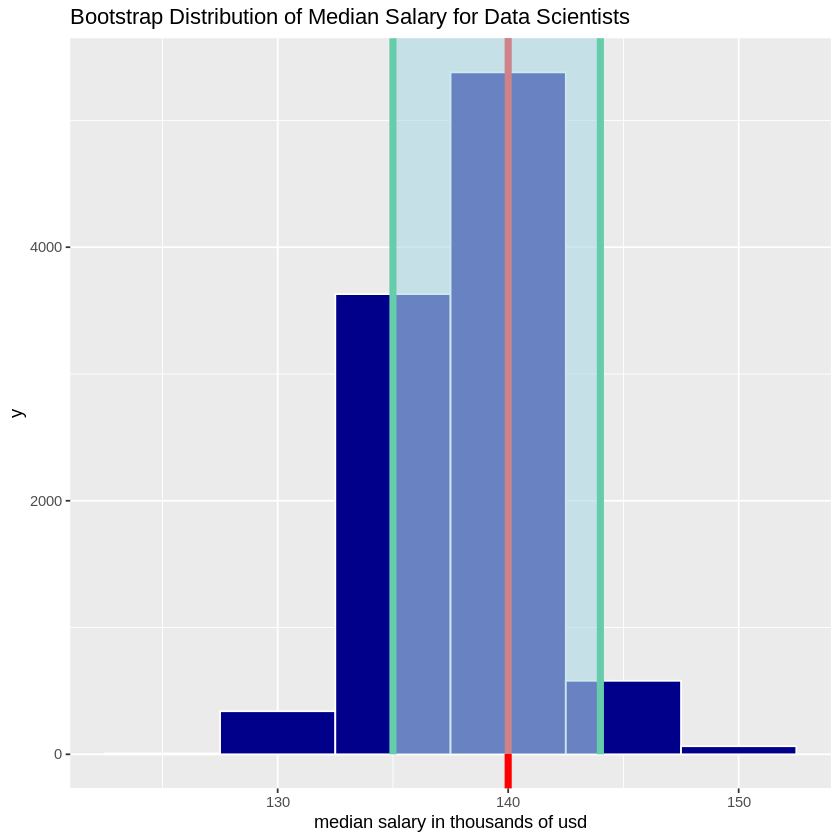

In [15]:
ds_workers_bootstrap_plot <-
    ds_workers_bootstrap_dist %>%
    ggplot(aes(x = stat/1000)) +
    geom_histogram(binwidth = 5, color="white", fill="darkblue" ) +
    geom_vline(size = 2, xintercept = ds_workers_median, color="red") +
    shade_confidence_interval(ds_workers_ci1, fill = "lightblue") +
    xlab("median salary in thousands of usd") +
    ggtitle("Bootstrap Distribution of Median Salary for Data Scientists")

ds_workers_bootstrap_plot

#### Bootstrap Distribution for Differences in Medians between remote majority and remote minority groups

##### Table 2.3 Median Salary Difference

In [16]:
set.seed(2314)
clean_data$remote_ratio <- as.factor(clean_data$remote_ratio)

med_diff_bootstrap_dist <-
    clean_data %>%
    specify(formula = salary_in_usd ~ remote_ratio) %>%
    generate(type="bootstrap", reps = 10000) %>%
    calculate(stat = "diff in medians", order = c(100, 0)) %>% 
    mutate(stat = stat / 1000) 

head(med_diff_bootstrap_dist)

replicate,stat
<int>,<dbl>
1,1.800
2,10.000
3,12.500
4,14.854
5,11.000
6,15.000


##### Point Estimate for Observed Median Difference 

In [17]:
# Note point estimate has been scaled by a factor of 1/1000

obs_diff_in_medians <- 
    clean_data %>%
    specify(formula = salary_in_usd ~ remote_ratio) %>%
    calculate(stat = "diff in medians", order = c(100, 0))%>%
    mutate(stat = stat / 1000) %>%
    pull()

obs_diff_in_medians 

[1] 10

##### Table 2.4 90% Confidence Interval for difference between remote majority and remote minority groups

In [18]:
diff_ci <- med_diff_bootstrap_dist %>% 
        get_confidence_interval(level = 0.90, type="percentile")

diff_ci

lower_ci,upper_ci
<dbl>,<dbl>
-1.1,25


We are 90% confidence that the true difference in median salary for Data Scientists (remote majority - remote minority) lies somewhere between USD -1100 and USD 25000. Note that USD zero is contained within this interval

##### **Figure 2.3** Histogram of Bootstrap Distribution with 90% Confidence Interval for Median Difference between remote majority and remote minority groups

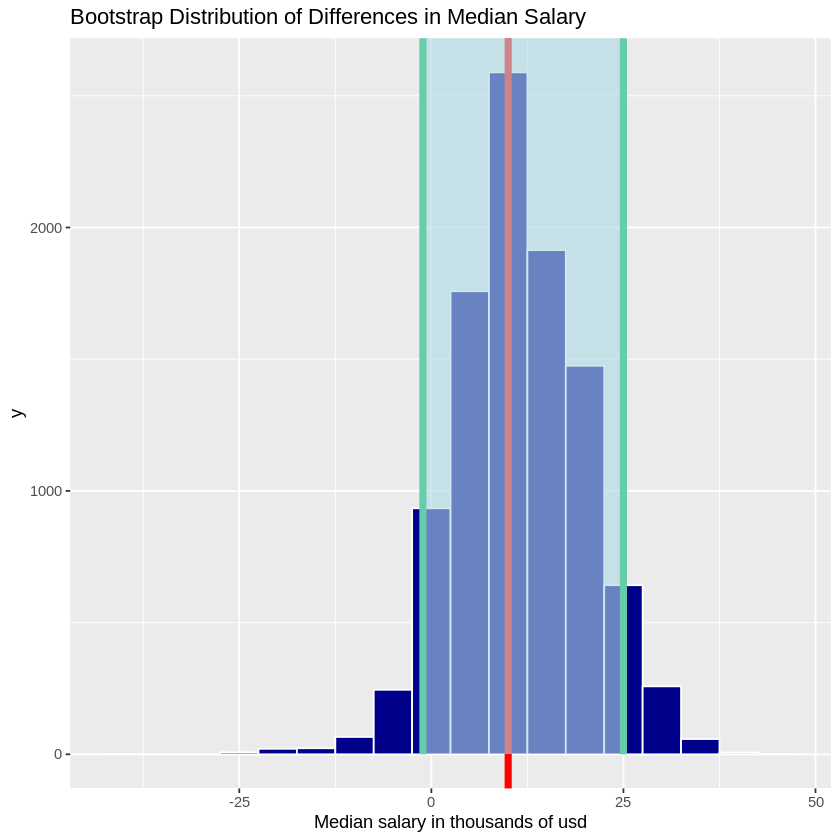

In [19]:
med_diff_bootstrap_plot <-
    med_diff_bootstrap_dist %>%
    ggplot(aes(x = stat)) +
    geom_histogram(binwidth = 5, color="white", fill="darkblue" ) +
    geom_vline(size = 2, xintercept = obs_diff_in_medians, color="red") +
    shade_confidence_interval(diff_ci, fill="lightblue") +
    xlab("Median salary in thousands of usd") +
    ggtitle("Bootstrap Distribution of Differences in Median Salary")

med_diff_bootstrap_plot

#### 3. Hypotheses

##### Hypothesis Test 1: Comparing Remote-Majority and Remote-Minority Median Salaries

Null Hypothesis: full-time US remote-minority and remote-majority positions have the same median income.

Alternative Hypothesis: full-time US remote-minority and remote-majority positions have different median income.

The significance level is set to 10%; neither Type I or Type II errors are life-altering, and predominantly impact salary difference expectations of the reader, which may nevertheless be updated as they search and apply for data science positions. Hence, whether the significance level is set at 5% or 10% should not be of great consequence from a risk-management point of view.

##### Calculate the Observed Difference in Median Incomes

In [20]:
# Already Calculated above in previous section check Table 2.4
obs_diff_in_medians * 1000

[1] 10000

The observed difference in median income between the two groups is USD 10000.

##### **Table 3.1** Create a Null Model for the Difference in Median Salaries

In [21]:
set.seed(50)

null_model<-
    clean_data %>%
    specify(formula = salary_in_usd ~ remote_ratio) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 10000, type = "permute") %>%
    calculate(stat = "diff in medians", order = c(100, 0))%>%
    mutate(stat = stat / 1000)

head(null_model)

replicate,stat
<int>,<dbl>
1,5.000
2,-0.825
3,2.000
4,7.805
5,10.400
6,-10.993


##### **Figure 3.1** Plot of Null Model with Observed Difference

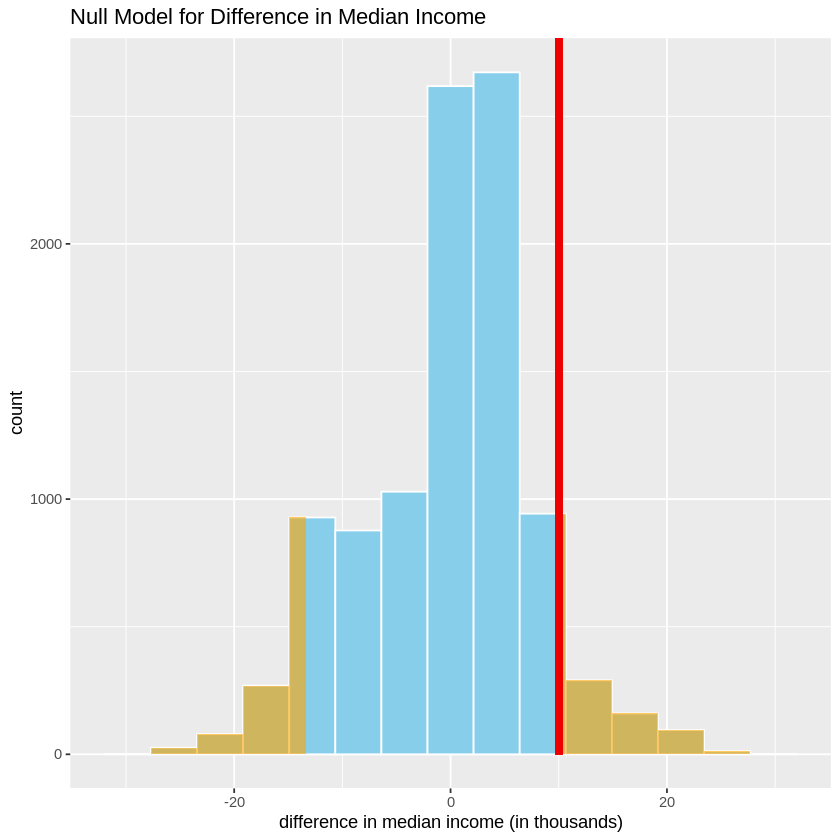

In [22]:
null_model_plot <- null_model %>%
                    visualize(fill = "skyblue") +
                    shade_p_value(obs_stat = obs_diff_in_medians, direction = "both", fill = "orange")+
                    xlab("difference in median income (in thousands)") +
                    ggtitle("Null Model for Difference in Median Income") 

null_model_plot

##### p-value of observed difference assuming correctness of Null Model

In [23]:
p_value <- null_model %>%
    get_p_value(obs_stat = obs_diff_in_medians, direction = "both") %>%
    pull()

p_value

[1] 0.2002

##### Table 3.2 Errors

Since we have failed to reject the null hypothesis we are subject to Type II error. Since we do not have access to the population distribution nor the sample distribution we must use the bootstrap sample as a substitute. 

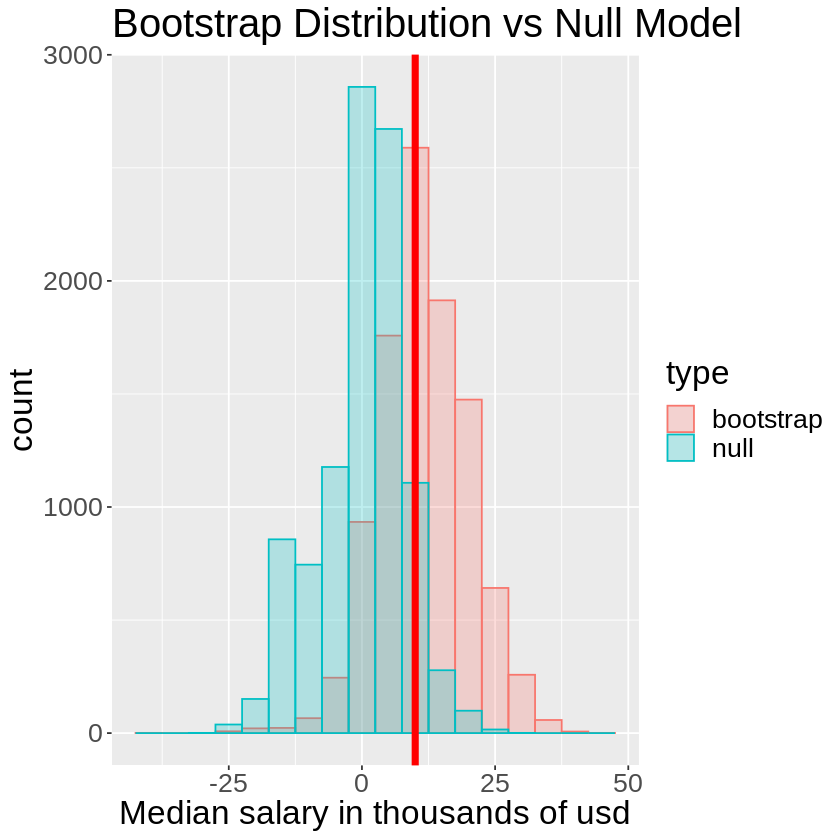

In [24]:
# Visualization to assist in Finding Type II Error

med_diff_bootstrap_dist_label <- med_diff_bootstrap_dist %>% mutate(type = "bootstrap") 
null_model_label <- null_model %>% mutate(type = "null")

both_plots <- med_diff_bootstrap_dist_label %>% 
    bind_rows(null_model_label) %>% 
    ggplot() + 
    geom_histogram(aes(stat, color= type, fill= type), alpha=.25, binwidth = 5, position="identity" ) +
    geom_vline(size = 2, xintercept = obs_diff_in_medians, color="red") +
    theme(text = element_text(size=20)) + 
    xlab("Median salary in thousands of usd") + 
    ggtitle("Bootstrap Distribution vs Null Model")

both_plots

##### Type II Error

In [25]:
diff_type_ii <- med_diff_bootstrap_dist %>% 
    summarise(prop = mean(stat < obs_diff_in_medians))

diff_type_ii

prop
<dbl>
0.4365


#### Hypothesis 1: Discussion

The p-value observed (approximately 20%) is greater than the significance level of 10%. We therefore do not have sufficient evidence to reject the null hypothesis.  

Based on our research, there is not sufficient data to conclude that Data Scientists working in remote-minority positions make a different income from Data Scientists working in remote-majority positions. 

This is not what we expected to find; prior to conducting the study our expectation was that there would be some difference in median salary between the groups, likely with remote-minority positions in general offering higher salaries, in order to compensate and entice workers who would otherwise prefer the flexibility of remote-majority positions. 

Our study's results may be due to peculiarities of the dataset used; as mentioned in the Methods section, one of the concerns we had of our dataset is that its observations are self-reported and thus may suffer from selection-bias impacting the results.  However, it is also possible that there is something in the nature of Data Science work that, from an employer's perspective, there is little productivity difference from having employees work remotely versus onsite. It could also be the case that those professionals in remote-majority positions have greater career leverage than their remote-minority counterparts, and hence are able to enjoy the perks of remote-work without impact to their salary. 

Commission of Type II error is possible, i.e. we may be concluding that median income between remote-majority and remote-minority positions are the same when in reality there is a difference.  Committing this type of error may result in readers having the inaccurate belief that the mode of work (remote vs non-remote) has no impact on expected salary. Given that such beliefs can be updated as Data Science professionals search for jobs, and that job offers are accepted or declined on their individual merits, we do not perceive the consequences of committing a Type II error to be highly problematic.

Further research questions include whether this result is consistent across all levels of career progression amongst Data Science professionals, or whether there are observed median income differences for remote vs non-remote depending on experience and role type.  Relatedly, investigating whether different career levels have differences in the predominance of remote work positions might shed light our current findings.

#### Hypothesis Test 2: True Median Salary for Data Scientists (Overall)

Null Hypothesis: true median for full time, US Data Scientists is as stated in US News and World Report i.e. USD 98,230.

Alternative Hypothesis: true median for full time US Data Scientists is different than the figure stated by US News and World Report. 

Signifiance level is set to 10%; risk assessment for Type I and Type II errors is similar for this hypothesis as it was for Hypothesis Test 1. 

##### **Table 3.2** Null Model for Data Science (overall) Median Salary

In [26]:
set.seed(129)
null_median <- 98230

overall_median_nullmodel <- ds_workers %>%
    specify(response = salary_in_usd) %>%
    hypothesise(null = "point", med = null_median) %>%
    generate(reps = 10000, type = "bootstrap") %>%
    calculate(stat = "median") %>% 
    mutate(stat = stat / 1000)
    
head(overall_median_nullmodel)    

replicate,stat
<int>,<dbl>
1,109.7550
2,96.7490
3,94.7550
4,100.0800
5,96.5620
6,96.8225


##### **Figure 3.2** Plot of Null Model with Observed Median Salary

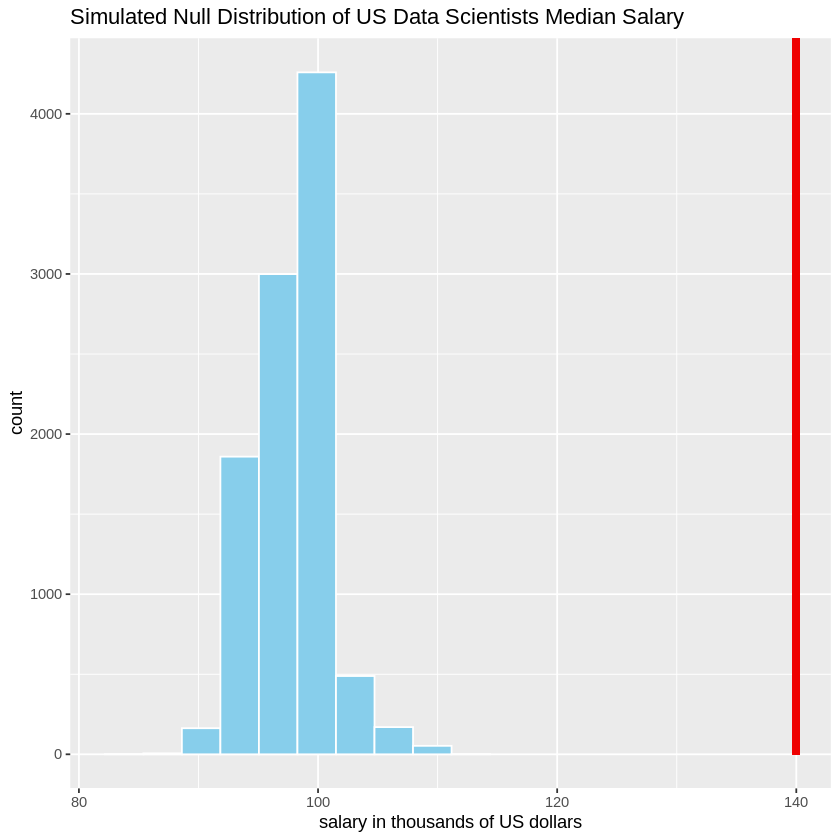

In [27]:
observed_median <- 140000 / 1000 

overall_median_nullmodel_plot <- 
    overall_median_nullmodel %>%
    visualize(fill="skyblue", bins = 10) +
    shade_p_value(obs_stat = observed_median, direction = "both", fill = "orange") +
    xlab("salary in thousands of US dollars") +
    ggtitle("Simulated Null Distribution of US Data Scientists Median Salary")
    

overall_median_nullmodel_plot

In [28]:
# change right to both

overall_median_p_value <- 
    overall_median_nullmodel %>%
    get_p_value(obs_stat = observed_median, direction = "both") %>%
    pull()

overall_median_p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


[1] 0

##### Table 3.3 Comparison of Null and Bootstrap Distribution

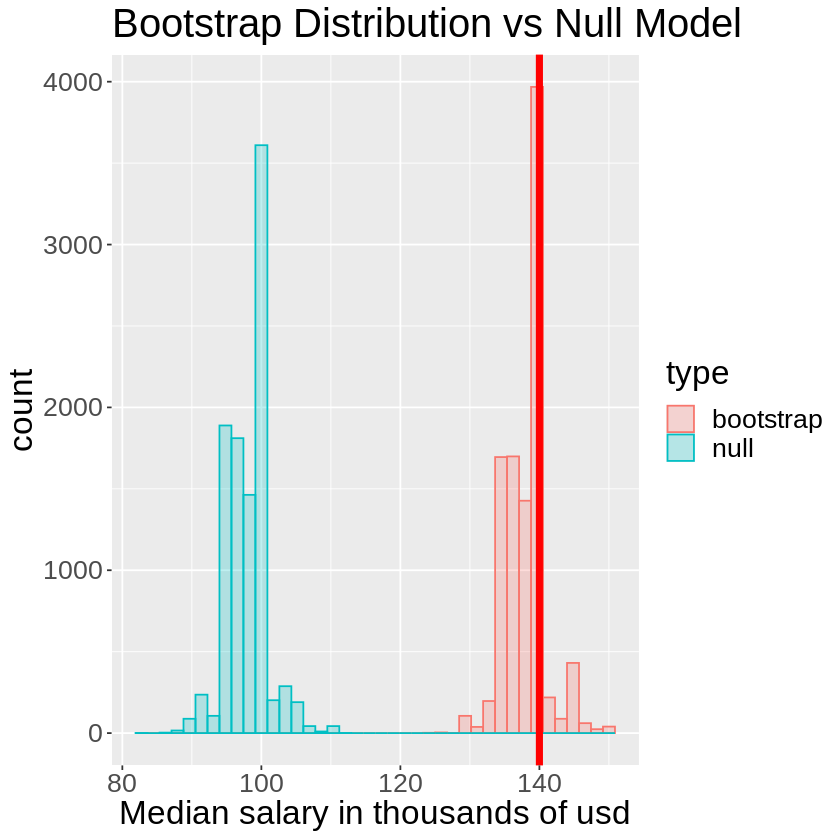

In [29]:
overall_null_labelled <- overall_median_nullmodel %>% 
    mutate(type = "null")

ds_workers_bootstrap_labelled <- ds_workers_bootstrap_dist %>% 
    mutate(type = "bootstrap") %>% 
    mutate(stat = stat / 1000)

both_plots <- ds_workers_bootstrap_labelled %>% 
    bind_rows(overall_null_labelled) %>% 
    ggplot() + 
    geom_histogram(aes(stat, color= type, fill= type), alpha=.25, bins=40, position="identity" ) +
    geom_vline(size = 2, xintercept = observed_median, color="red") +
    theme(text = element_text(size=20)) + 
    xlab("Median salary in thousands of usd") + 
    ggtitle("Bootstrap Distribution vs Null Model")

both_plots

#### Hypothesis 2: Discussion

Note that we interpret the p-value to mean a very low probability that is arbitrarily close to 0.

Based on the p-value, we reject the null hypothesis at a 10% significance level and conclude that, the median income observed from the dataset is not consistent with the median salary being USD 98230.

Having performed a preliminary investigation of the dataset, this result is not unexpected; the dataset's median salary value is substantially greater than that which is reported by US News and World Report (USD 140000 vs USD 98230), and so the observed median salary seemed to be inconsistent with a null model centered around USD 98230. 

However, this conclusion should be taken with caution, as there are limitations to the utilized dataset compared to the data used by US News and World Report.  US News and World Report utilizes data from the US Bureau of Labor Statistics, whose function is to collect employment-related data for the US federal government, and updates its data every quarter. The Bureau of Labor Statistics uses highly qualified economists, that use a variety of data collection methods, and is generally considered a reliable source for employment information.  In contrast, the dataset we used for this study is composed of self-reported observations, is subject to selection-bias, and thus may not be representative of Data Scientists as a whole.

Hence, despite the low observed p-value from this study, we cannot say definitely that we have demonstrated that the true median salary of Data Scientists is not USD 98230.

### REFERENCES

Bhatia, R, (2022), Data Science Job Salaries, [Data set]. Kaggle. https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries. 

Data Science Jobs Guide: Resources for a Career in Tech. (2022, July 21). Coursera. https://www.coursera.org/articles/data-science-jobs.

Elshaiekh, N. E. M., Hassan, Y. A. A., & Abdallah, A. A. A. (2018). The Impacts of Remote Working on Workers Performance. 2018 International Arab Conference on Information Technology (ACIT), 1–5. https://doi.org/10.1109/ACIT.2018.8672704

Ozimek, A. (2020). The Future of Remote Work. SSRN Electronic Journal. https://doi.org/10.2139/ssrn.3638597.

Zaire, C. (2021, November 8). Is Data Science Still a Rising Career in 2021. Towards Data Science. https://towardsdatascience.com/is-data-science-still-a-rising-career-in-2021-722281f7074c.

US News and World Report article on data science: https://money.usnews.com/careers/best-jobs/data-scientist